In [1]:
import sys
sys.path.insert(1, "../")

import importlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.special import erf
import math

In [2]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.ds_fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset, default_mappings

from ghost_unfairness.utils import *

In [3]:
protected = ["sex"]
privileged_classes = [['Male']]
metadata = default_mappings.copy()
metadata['protected_attribute_maps'] = [{1.0: 'Male', 0.0: 'Female'}]

alpha = 0.5
beta = 1

kwargs = {'protected_attribute_names': protected,
          'privileged_classes': [['Male']],
          'metadata':metadata,
          'favorable_classes': [1],
          'beta': beta,
          'alpha': alpha,
          'ds': True,
          'n_dep_feat': 0
         }

random_state = 23
model_type = GaussianNB

In [67]:
def print_model_performances(model, test_fd):
    test_fd_x, test_fd_y = test_fd.get_xy(keep_protected=False)
    data = test_fd.copy()
    data_pred = test_fd.copy()

    data_pred.labels = mod_pred = model.predict(test_fd_x)
    metrics = ClassificationMetric(data,
                                   data_pred,
                                   privileged_groups=test_fd.privileged_groups,
                                   unprivileged_groups=test_fd.unprivileged_groups)

    # print(metrics.binary_confusion_matrix())
    print('SR\t', metrics.selection_rate())

    # print('PCNFM\t', metrics.binary_confusion_matrix(privileged=True))
    print('PSR\t', metrics.selection_rate(privileged=True))
    print('PTPR\t', metrics.true_positive_rate(privileged=True))
    print('PFPR\t', metrics.false_positive_rate(privileged=True))
    # print('PFDR\t', metrics.false_discovery_rate(privileged=True))
    # print('UCNFM\t', metrics.binary_confusion_matrix(privileged=False))
    print('USR\t', metrics.selection_rate(privileged=False))
    print('UTPR\t', metrics.true_positive_rate(privileged=False))
    print('UFPR\t', metrics.false_positive_rate(privileged=False))
    # print('UFDR\t', metrics.false_discovery_rate(privileged=False))
    return metrics, mod_pred

In [5]:
def get_theoretical_model(mod, dist):
    
    mu_1_avg = (dist['mu_ps']['p'] + dist['mu_ns']['p'])/2
    mu_1_pos = (dist['mu_ps']['p'] + mu_1_avg)/2
    mu_1_neg = (dist['mu_ns']['p'] + mu_1_avg)/2
    
    mu_2_avg = (dist['mu_ps']['u'] + dist['mu_ns']['u'])/2
    mu_2_pos = (dist['mu_ps']['u'] + mu_2_avg)/2
    mu_2_neg = (dist['mu_ns']['u'] + mu_2_avg)/2
    
    mod.theta_ = np.array([[mu_1_neg, mu_2_neg],
                           [mu_1_pos, mu_2_pos]])
    
    sigma_1 = dist['sigma_ps']['p'] ** 2 + (dist['mu_ps']['p'] - mu_1_avg)**2/4
    sigma_2 = dist['sigma_ps']['u'] ** 2 + (dist['mu_ps']['u'] - mu_2_avg)**2/4
    mod.sigma_ = np.array([[sigma_1, sigma_2],
                           [sigma_1, sigma_2]])
    
    print(mod.theta_)
    print(mod.sigma_)
    
    return mod

In [70]:
from sklearn.tree import plot_tree as plot_tree
dist = {
    'mu_ps': {'p': 103, 'u': 100},
    'sigma_ps': {'p': 80, 'u': 200},
    'mu_ns': {'p': 3,'u': 0},
    'sigma_ns': {'p': 80, 'u': 200}
}

results = {'p' : [], 'u': [], 'm': []}
temp_dist = deepcopy(dist)
kwargs['dist'] = temp_dist
print(kwargs['dist'])   
model_type = GaussianNB

mods = []

for alpha in [0.1, 0.25, 0.5, 0.75, 0.9]:
    print('alpha', alpha)
    kwargs['alpha'] = alpha
    kwargs['shift_random'] = 0
    kwargs['shift_priv'] = False
    kwargs['verbose'] = False
    train_fd, test_fd = get_datasets(10000, 0, 1, kwargs, test_random_state=41)
    pmod, pmod_results = get_groupwise_performance(train_fd, test_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, test_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, test_fd, model_type,
                                                 privileged=None, pos_rate=True)
    
    mods.append(mod)
    
    # print(test_fd.privileged_groups)
    
    if False:
        print('Theta')
        print(pmod.theta_)
        print(umod.theta_)
        print(mod.theta_)

        print('Sigma')
        print(pmod.sigma_)
        print(umod.sigma_)
        print(mod.sigma_)
        
        print(mod.class_prior_)
    
    is_u_optimal = umod_results[4] > pmod_results[4]
    is_p_optimal = pmod_results[3] > umod_results[3]
    is_m_optimal = mod_results[2] > umod_results[2] and mod_results[2] > pmod_results[2]

    opt_diff = is_u_optimal and is_p_optimal and is_m_optimal

    violates = mod_results[1] > umod_results[1] and mod_results[1] > pmod_results[1]

    # print(opt_diff)

    # print('Violates', opt_diff and violates)

    
    # print('pmod_results', *['{:.4f}'.format(i) for i in pmod_results], sep='\t')
    # print('umod_results', *['{:.4f}'.format(i) for i in umod_results], sep='\t')
    # print('mod_results', *['{:.4f}'.format(i) for i in mod_results], sep='\t')
    
    # print('pmod')
    # _, pmod_pred = print_model_performances(pmod, test_fd)
    # print('umod')
    # _, umod_pred = print_model_performances(umod, test_fd)
    print('mod')
    _, mod_pred = print_model_performances(mod, test_fd)
    """print('Theoretical Bounds')
    mod = get_theoretical_model(mod, dist)
    _, mod_pred = print_model_performances(mod, test_fd)
    """

    # print(np.unique(pmod_pred == mod_pred, return_counts=True))
    # print(np.unique(umod_pred == mod_pred, return_counts=True))


{'mu_ps': {'p': 103, 'u': 100}, 'sigma_ps': {'p': 80, 'u': 200}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 80, 'u': 200}}
alpha 0.1


c:\python38_64\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


mod
SR	 0.0005
PSR	 0.0004
PTPR	 0.004
PFPR	 0.0
USR	 0.0006
UTPR	 0.004
UFPR	 0.00022222222222222223
alpha 0.25
mod
SR	 0.0393
PSR	 0.0368
PTPR	 0.1144
PFPR	 0.010933333333333333
USR	 0.0418
UTPR	 0.0608
UFPR	 0.03546666666666667
alpha 0.5
mod
SR	 0.5032
PSR	 0.5082
PTPR	 0.726
PFPR	 0.2904
USR	 0.4982
UTPR	 0.5332
UFPR	 0.4632
alpha 0.75
mod
SR	 0.9626
PSR	 0.9574
PTPR	 0.9888
PFPR	 0.8632
USR	 0.9678
UTPR	 0.9722666666666666
UFPR	 0.9544
alpha 0.9
mod
SR	 0.9998
PSR	 0.9998
PTPR	 1.0
PFPR	 0.998
USR	 0.9998
UTPR	 0.9997777777777778
UFPR	 1.0


0 0
(-3, 19) (-15, 25)
(13, 3)
(2, 2)
(5.0, 5.0)
(5, 5)
(8.0, 8.0)
(2, 2)
(10, 0)
(5, 5)


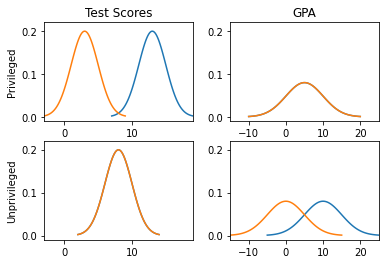

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def plot_normal(mu, sigma, ax, label=None):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), label=label)

f, ax = plt.subplots(2, 2)
shift_p = 0
shift_u = 0
if kwargs['shift_priv'] == True:
    shift_u = kwargs['shift_random']
if kwargs['shift_priv'] == False:
    shift_p = kwargs['shift_random']
print(shift_p, shift_u)
avg_p = (dist['mu_ps']['p'] + dist['mu_ns']['p'])/2 + shift_p
avg_u = (dist['mu_ps']['u'] + dist['mu_ns']['u'])/2 + shift_u
sigma_p = dist['sigma_ps']['p']
sigma_u = dist['sigma_ps']['u']
p_range = (min(dist['mu_ps']['p'], dist['mu_ns']['p']) - 3 * sigma_p, 
           max(dist['mu_ps']['p'], dist['mu_ns']['p']) + 3 * sigma_p
          )
u_range = (min(dist['mu_ps']['u'], dist['mu_ns']['u']) - 3 * sigma_u, 
           max(dist['mu_ps']['u'], dist['mu_ns']['u']) + 3 * sigma_u
          )
print(p_range, u_range)

combs = [
    [
        [(dist['mu_ps']['p'], dist['mu_ns']['p']), (sigma_p, sigma_p), p_range], 
        [(avg_u, avg_u), (sigma_u, sigma_u), u_range]
    ],
    [
        [(avg_p, avg_p), (sigma_p, sigma_p), p_range], 
        [(dist['mu_ps']['u'], dist['mu_ns']['u']), (sigma_u, sigma_u), u_range]
    ]
]

for i, row in enumerate(ax):
    for j, a in enumerate(row):
        mus = combs[i][j][0]
        sigmas = combs[i][j][1]
        print(mus)
        print(sigmas)
        plot_normal(mus[0], sigmas[0], a)
        plot_normal(mus[1], sigmas[1], a)
        left, right = combs[i][j][2]
        # left = min(mus[0] - 3 * sigmas[0], mus[1] - 3 * sigmas[1])
        # right = max(mus[1] + 3 * sigmas[1], mus[1] + 3 * sigmas[1])
        a.set_xlim(left,right)
        a.set_ylim(-0.01, 0.22)
        # a.vlines(np.mean(mus), 0, 0.2, color='red')
        
ax[0][0].set_title('Test Scores')
ax[0][1].set_title('GPA')

ax[0][0].set_ylabel('Privileged')
ax[1][0].set_ylabel('Unprivileged')

plt.subplots_adjust(wspace=0.25)

In [8]:
def conditional_probs(clf, x):
    temp = (clf.theta_ - x.values)
    temp = temp / clf.sigma_
    temp = (temp ** 2)/2
    temp = np.exp(- temp)
    temp = temp / np.sqrt(2 * 3.1416 * (clf.sigma_))
    # temp = np.prod(temp, axis=1)
    # temp = umod.class_prior_ * temp
    # temp = temp/ np.sum(temp)
    return temp

i = 4000
test_fd_x, _ = test_fd.get_xy(keep_protected=False)
print(test_fd_x.iloc[i:i+1])
print(test_fd.protected_attributes[i])
print(test_fd.labels[i])
print(conditional_probs(pmod, test_fd_x.iloc[i:i+1]))
print(conditional_probs(umod, test_fd_x.iloc[i:i+1]))
print(conditional_probs(mod, test_fd_x.iloc[i:i+1]))

          r_p_0     r_u_0
4000  13.622556  1.742254
[1.]
[1.]
[[0.008322   0.0767634 ]
 [0.19748489 0.07857089]]
[[0.0745427  0.08321052]
 [0.07585078 0.07558357]]
[[0.09103031 0.0713439 ]
 [0.11895843 0.07016378]]


In [9]:
dist

{'mu_ps': {'p': 13, 'u': 10},
 'sigma_ps': {'p': 2, 'u': 5},
 'mu_ns': {'p': 3, 'u': 0},
 'sigma_ns': {'p': 2, 'u': 5}}

In [10]:
mod.__dict__

{'priors': None,
 'var_smoothing': 1e-09,
 'n_features_in_': 2,
 'epsilon_': 3.2687804741440495e-08,
 'classes_': array([0., 1.]),
 'theta_': array([[ 5.5,  2.5],
        [10.5,  7.5]]),
 'sigma_': array([[10.25, 31.25],
        [10.25, 31.25]]),
 'class_count_': array([ 1000., 19000.]),
 'class_prior_': array([0.05, 0.95])}

In [11]:
def get_expected_x(dist, priv, ispos):
    x1, x2 = get_mus(dist, priv, ispos)
    if priv:
        x2 = x2 + 0 * dist['sigma_ps']['u']  
    else:
        x1 = x1 + 0 * dist['sigma_ps']['p']
        
    print(x1, x2)
    return x1, x2

def get_mus(dist, priv, ispos):
    if priv:
        mu2 = (dist['mu_ps']['u'] + dist['mu_ns']['u'])/2
        if ispos:
            mu1 = dist['mu_ps']['p']
        else:
            mu1 = dist['mu_ns']['p']
    else:
        mu1 = (dist['mu_ps']['p'] + dist['mu_ns']['p'])/2
        if ispos:
            mu2 = dist['mu_ps']['u']
        else:
            mu2 = dist['mu_ns']['u']
        
    # print(mu1, mu2)
    
    return mu1, mu2

In [12]:
from scipy.stats import norm
def get_cdf(mu, sigma, x):
    rv = norm(loc=mu, scale=sigma)
    return rv.cdf(x)

In [13]:
ex1, ex2 = get_expected_x(dist, priv=True, ispos=True)

13 5.0


In [14]:
def get_bounds(alpha, ex1, ex2):
    c = math.log(alpha/(1-alpha))
    x1_bound = 8 - 10.2/5*(c + 5/31.5*(ex2 - 5))
    x2_bound = 5 - 31.5/5*(c + 5/10.2*(ex1 - 8))
    return x1_bound, x2_bound

In [15]:
x1, x2 = get_bounds(0.25, ex1, ex2)
x1, x2

(10.241169068882943, -3.5199190519791443)

In [16]:
'{:.8f}'.format((1 - get_cdf(ex1, 2, x1))*(1 - get_cdf(ex2, 5, x2)))

'0.87563157'

In [17]:
(1 - get_cdf(ex1, 2, x1))

0.9161166532097544

In [18]:
(1 - get_cdf(ex2, 5, x2))

0.9558079440723021

In [19]:
rv = norm(loc=8, scale=2)
exp = 0
for i in np.arange(-20, 30, 0.01):
    prob = rv.pdf(i)
    fx = 0.01 * erf((36.2565 - 3.0488 * i)/(5 * math.sqrt(2)))
    exp += fx*prob
    
print(exp)
    

0.8676256796541201


In [20]:
1/2 - 0.5*exp

0.06618716017293996

## Theoretical Bounds

In [21]:
def get_a(sigma_1_theta, sigma_2_theta, sigma_2):
    return - (sigma_2_theta / sigma_1_theta) ** 2 / (math.sqrt(2) * sigma_2)

def get_b(sigma_1_theta, sigma_2_theta, sigma_1, sigma_2, mu_1_avg, mu_2_avg, mu, alpha, delta):
    temp = (mu_2_avg - mu)
    temp += (sigma_2_theta / sigma_1_theta) ** 2 * mu_1_avg
    temp -= (sigma_2_theta ** 2 / delta) * math.log(alpha/(1-alpha))
    temp /= (math.sqrt(2) * sigma_2)
    return temp    

def get_selection_rate(s, is_pos, dist, dist_theta, delta, alpha):
    if is_pos:
        if s == 'p':
            mu_1 = dist['mu_ps']['p']
            mu_2 = dist_theta['mu'][2]
        else:
            mu_1 = dist_theta['mu'][1]
            mu_2 = dist['mu_ps']['u']
    else:
        if s == 'p':
            mu_1 = dist['mu_ns']['p']
            mu_2 = dist_theta['mu'][2]
        else:
            mu_1 = dist_theta['mu'][1]
            mu_2 = dist['mu_ns']['u']

    sigma_1_theta = dist_theta['sigma'][1]
    sigma_2_theta = dist_theta['sigma'][2]
    sigma_1 = dist['sigma_ps']['p']
    sigma_2 = dist['sigma_ps']['u']
    mu_1_avg = dist_theta['mu'][1]
    mu_2_avg = dist_theta['mu'][2]
    
    a = get_a(sigma_1_theta, sigma_2_theta, sigma_2)
    b = get_b(sigma_1_theta, sigma_2_theta, sigma_1, sigma_2, 
              mu_1_avg, mu_2_avg, mu_2, alpha, delta)
    # print((a * mu_1 + b)/np.sqrt(1+a**2 * sigma_1**2))
    # print(np.sqrt(1+a**2 * sigma_1**2))
    
    return 0.5 * (1 - erf((a * mu_1 + b)/np.sqrt(1+a**2 * sigma_1**2)))

In [22]:
dist = {
    'mu_ps': {'p': 103, 'u': 100},
    'sigma_ps': {'p': 40, 'u': 110},
    'mu_ns': {'p': 3,'u': 0},
    'sigma_ns': {'p': 40, 'u': 110}
}

delta = dist['mu_ps']['p'] - dist['mu_ns']['p']

mu_1_avg = (dist['mu_ps']['p'] + dist['mu_ns']['p']) / 2
mu_2_avg = (dist['mu_ps']['u'] + dist['mu_ns']['u']) / 2
sigma_1_theta = np.sqrt(dist['sigma_ps']['p']**2 
                        + (dist['mu_ps']['p'] - dist['mu_ns']['p'])**2 / 16)
sigma_2_theta = np.sqrt(dist['sigma_ps']['u']**2 
                        + (dist['mu_ps']['u'] - dist['mu_ns']['u'])**2 / 16)
dist_theta = {'mu': {1: mu_1_avg, 2: mu_2_avg},
             'sigma': {1: sigma_1_theta, 2: sigma_2_theta}
             }
print(mu_1_avg, mu_2_avg, sigma_1_theta, sigma_2_theta, delta)

53.0 50.0 47.16990566028302 112.80514172678478 100


In [23]:
get_selection_rate('p', True, dist, dist_theta, delta, 0.25)

0.7725142260923433

In [24]:
get_selection_rate('p', False, dist, dist_theta, delta, .25)

0.014760783551900025

In [25]:
get_selection_rate('u', True, dist, dist_theta, delta, 0.25)

0.32309938259038007

In [26]:
get_selection_rate('u', False, dist, dist_theta, delta, 0.25)

0.16596117525660198

In [27]:
sigma_theta_1 = dist_theta['sigma'][1]
sigma_theta_2 = dist_theta['sigma'][2]
sigma_1 = dist['sigma_ps']['p']
sigma_2 = dist['sigma_ps']['u']
a = (sigma_theta_2/sigma_theta_1) ** 2 / (math.sqrt(2) * sigma_2)
c1 = a * delta / (2  * np.sqrt(1 + (a * sigma_1)**2))
print(c1)
c3 = delta / (2 * np.sqrt(2) * sigma_2 * np.sqrt(1 + (a**2 * sigma_1**2)))
print(c3)
alpha = 0.25
c2 = (sigma_theta_2)**2 / (delta * np.sqrt(2) * sigma_2 * np.sqrt(1 + (a * sigma_1)**2))
print(c2)
c_alpha = np.log(alpha/(1-alpha))
print(c_alpha)
4 * c3 * (sigma_theta_2)**2 / (delta * np.sqrt(2) * sigma_2 * np.sqrt(1 + (a * sigma_1)**2)) < 1

1.033649846800481
0.1807364172205163
0.4599741818262142
-1.0986122886681098


True

In [28]:
temp_dist = deepcopy(dist)

print('i', ['c1', 'c2', 'c3', 'c1 + c2', 'c3 + c2', 'c1 - c2', 'c3 - c2'], sep='\t')
def func(sigma_1, sigma_2, delta):
    sigma_theta_1 = np.sqrt(sigma_1**2 + delta**2/16)
    sigma_theta_2 = np.sqrt(sigma_2**2 + delta**2/16)
    
    lhs = (delta**2 / 16) * (sigma_theta_2**2 + sigma_theta_1**2)
    rhs = (sigma_theta_2**2 * sigma_1**2 + sigma_theta_1**2 * sigma_2**2)
    print(sigma_1, sigma_2, sigma_theta_1, sigma_theta_2, int(lhs), int(rhs))
    return lhs> rhs

temp_dist = {
    'mu_ps': {'p': 103, 'u': 100},
    'sigma_ps': {'p': 30, 'u': 110},
    'mu_ns': {'p': 3,'u': 0},
    'sigma_ns': {'p': 30, 'u': 110}
}

for i in range(30, 200, 10):
    temp_dist['sigma_ps']['u'] = temp_dist['sigma_ns']['u'] = i
    sigma_1 = temp_dist['sigma_ps']['p']
    sigma_2 = temp_dist['sigma_ps']['u']
    sigma_theta_1 = np.sqrt(sigma_1**2 + delta**2/16)
    sigma_theta_2 = np.sqrt(sigma_2**2 + delta**2/16)
    a = (sigma_theta_2/sigma_theta_1) ** 2 / (math.sqrt(2) * sigma_2)
    c1 = a * delta / (2  * np.sqrt(1 + (a * sigma_1)**2))
    # print(c1)
    c3 = delta / (2 * np.sqrt(2) * sigma_2 * np.sqrt(1 + (a**2 * sigma_1**2)))
    # print(c3)
    alpha = 0.25
    c2 = (sigma_theta_2)**2 * np.log(alpha/(1-alpha)) / (delta * np.sqrt(2) * sigma_2 * np.sqrt(1 + (a * sigma_1)**2))
    # print(c2)
    cond = func(sigma_1, sigma_2, delta)
    print(i, ['{:.4f}'.format(f) for f in [c1, c2, c3, c1+c2, c3+c2, c1-c2, c3-c2]], cond, sep='\t')

i	['c1', 'c2', 'c3', 'c1 + c2', 'c3 + c2', 'c1 - c2', 'c3 - c2']
30 30 39.05124837953327 39.05124837953327 1906249 2744999
30	['0.9623', '-0.3224', '0.9623', '0.6398', '0.6398', '1.2847', '1.2847']	False
30 40 39.05124837953327 47.16990566028302 2343750 4442500
40	['1.0199', '-0.3418', '0.6991', '0.6782', '0.3573', '1.3617', '1.0408']	False
30 50 39.05124837953327 55.90169943749474 2906250 6625000
50	['1.0935', '-0.3664', '0.5336', '0.7271', '0.1672', '1.4599', '0.9000']	False
30 60 39.05124837953327 65.0 3593750 9292500
60	['1.1663', '-0.3908', '0.4210', '0.7755', '0.0302', '1.5570', '0.8117']	False
30 70 39.05124837953327 74.33034373659252 4406250 12445000
70	['1.2322', '-0.4129', '0.3401', '0.8193', '-0.0728', '1.6451', '0.7530']	False
30 80 39.05124837953327 83.81527307120105 5343750 16082499
80	['1.2896', '-0.4321', '0.2800', '0.8575', '-0.1522', '1.7217', '0.7121']	False
30 90 39.05124837953327 93.40770846134703 6406250 20205000
90	['1.3387', '-0.4486', '0.2340', '0.8902', '-0.21

(0.053023995525617935, 0.05342948072969357, 0.1)
(0.0986669245589741, 0.09941693359613071, 0.15000000000000002)
(0.1496926239591474, 0.15066157803401142, 0.20000000000000004)
(0.20419914418701096, 0.20524572709004668, 0.25000000000000006)
(0.26106788837976586, 0.2620638391071948, 0.30000000000000004)
(0.31956155295011995, 0.3204013775393985, 0.3500000000000001)
(0.3791482901901498, 0.3797523542056599, 0.40000000000000013)
(0.4394119858430373, 0.4397272480846831, 0.45000000000000007)
(0.5000000000000001, 0.5000000000000002, 0.5000000000000001)
(0.560588014156963, 0.5602727519153172, 0.5500000000000002)
(0.6208517098098506, 0.6202476457943406, 0.6000000000000002)
(0.6804384470498803, 0.6795986224606019, 0.6500000000000001)
(0.7389321116202344, 0.7379361608928057, 0.7000000000000002)
(0.7958008558129894, 0.7947542729099537, 0.7500000000000002)
(0.8503073760408529, 0.8493384219659887, 0.8000000000000002)
(0.9013330754410261, 0.9005830664038696, 0.8500000000000002)
(0.9469760044743822, 0.94

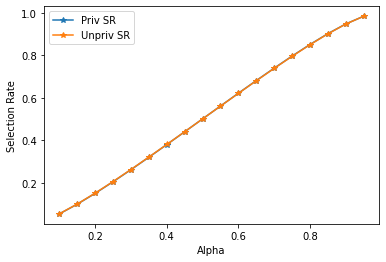

In [29]:
alphas = list(np.arange(.1, 1, 0.05))
tps = [get_selection_rate('p', True, dist, dist_theta, delta, alpha) for alpha in alphas]
# plt.plot(alphas, tps, label='Priv TP')
fps = [get_selection_rate('p', False, dist, dist_theta, delta, alpha) for alpha in alphas]
# plt.plot(alphas, fps, label='Priv FP')

# print(*list(zip(tps, fps, alphas)), sep='\n')

sr_p = [alphas[i] * tps[i] + (1 - alphas[i]) * fps[i] for i in range(len(alphas))]
plt.plot(alphas, sr_p, '*-', label='Priv SR')

tps = [get_selection_rate('u', True, dist, dist_theta, delta, alpha) for alpha in alphas]
# plt.plot(alphas, tps, label='Unpriv TP')
fps = [get_selection_rate('u', False, dist, dist_theta, delta, alpha) for alpha in alphas]
# plt.plot(alphas, fps, label='Unpriv FP')

# print()

# print(*list(zip(tps, fps, alphas)), sep='\n')

sr_u = [alphas[i] * tps[i] + (1 - alphas[i]) * fps[i] for i in range(len(alphas))]
plt.plot(alphas, sr_u, '*-', label='Unpriv SR')
# print()
print(*list(zip(sr_p, sr_u, alphas)), sep='\n')

plt.xlabel('Alpha')
plt.ylabel('Selection Rate')
plt.legend()
plt.savefig('theo_selection_rate_delta_{:d}_s1_{:d}_s2_{:d}.pdf'.
            format(delta, dist['sigma_ps']['p'], dist['sigma_ps']['u']), format='pdf')

In [30]:
def ddx_erf(x):
    return np.exp(-x**2)*2/np.sqrt(math.pi)

ddx_erf(2)

0.020666985354092053

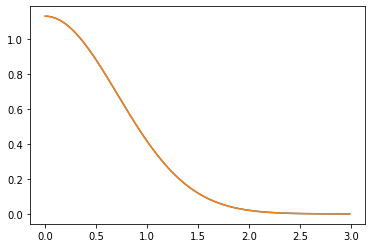

In [31]:
xs = np.arange(0, 3, 0.01)
plt.plot(xs, [ddx_erf(x) for x in xs])
xs = np.arange(0, 3, 0.01)
plt.plot(xs, [ddx_erf(x) for x in xs])

In [32]:
sigma_1 = 30
sigma_2 = 90
delta = 100
2 *(sigma_2**2 + delta/16) > (sigma_1**2 + delta/16) **2 * sigma_2**2 + (sigma_2**2 + delta/16) **2 * sigma_1**2


False

In [33]:
2 *(sigma_2**2 + delta/16)

16212.5

In [34]:
(sigma_1**2 + delta/16) **2 * sigma_2**2 + (sigma_2**2 + delta/16) **2 * sigma_1**2

65792601562.5

### Just random testing equations.

In [35]:
dist = {
    'mu_ps': {'p': 103, 'u': 100},
    'sigma_ps': {'p': 40, 'u': 110},
    'mu_ns': {'p': 3,'u': 0},
    'sigma_ns': {'p': 40, 'u': 110}
}

In [36]:
mu_1_p_plus = 13
mu_1_p_minus = 3
mu_1_u_plus = mu_1_u_minus = 8
mu_2_p_plus = mu_2_p_minus = 5
mu_2_u_plus = 10
mu_2_u_minus = 0
sigma_1 = 2
sigma_2 = 5
sigma_1_theta_sqr = 10.25
sigma_2_theta_sqr = 31.25

mu_1_avg = 8
mu_2_avg = 5

alpha = 0.25
c_alpha = np.log(alpha/(1-alpha))
delta = 10

Equation inside erf for $P(\hat{y}^+| y^+, p)$

In [37]:
b = mu_2_avg - mu_2_p_plus 
b += (mu_1_avg) * (sigma_2_theta_sqr)/sigma_1_theta_sqr
b -= sigma_2_theta_sqr/delta * c_alpha

b = b / (np.sqrt(2) * sigma_2)

a = - (sigma_2_theta_sqr/sigma_1_theta_sqr)*1/(np.sqrt(2) * sigma_2)
(a*mu_1_p_plus + b)/(np.sqrt(1 + 2 * a**2 * sigma_1**2))

-1.0590972600198978

In [38]:
numerator = sigma_1_theta_sqr * 0 * (-delta / 2) 
numerator += sigma_2_theta_sqr * 1 * (-delta / 2) 
numerator -= sigma_1_theta_sqr * sigma_2_theta_sqr * c_alpha / delta

denominator = sigma_1_theta_sqr ** 2 * sigma_2 ** 2
denominator += sigma_2_theta_sqr ** 2 * sigma_1 ** 2
denominator = np.sqrt(2 * denominator)
numerator / denominator

-1.0590972600198976

Equation inside erf for $P(\hat{y}^+| y^+, u)$

In [39]:
numerator = sigma_1_theta_sqr * 1 * (-delta / 2) 
numerator += sigma_2_theta_sqr * 0 * (-delta / 2) 
numerator -= sigma_1_theta_sqr * sigma_2_theta_sqr * c_alpha / delta

denominator = sigma_1_theta_sqr ** 2 * sigma_2 ** 2
denominator += sigma_2_theta_sqr ** 2 * sigma_1 ** 2
denominator = np.sqrt(2 * denominator)
numerator / denominator

-0.14050199082021922

Equation inside erf for $P(\hat{y}^+| y^-, p)$

In [40]:
numerator = sigma_1_theta_sqr * 0 * (delta / 2) 
numerator += sigma_2_theta_sqr * 1 * (delta / 2) 
numerator -= sigma_1_theta_sqr * sigma_2_theta_sqr * c_alpha / delta

denominator = sigma_1_theta_sqr ** 2 * sigma_2 ** 2
denominator += sigma_2_theta_sqr ** 2 * sigma_1 ** 2
denominator = np.sqrt(2 * denominator)
numerator / denominator

1.674817231645812

Equation inside erf for $P(\hat{y}^+| y^-, p)$

In [41]:
numerator = sigma_1_theta_sqr * 1 * (delta / 2) 
numerator += sigma_2_theta_sqr * 0 * (delta / 2) 
numerator -= sigma_1_theta_sqr * sigma_2_theta_sqr * c_alpha / delta

denominator = sigma_1_theta_sqr ** 2 * sigma_2 ** 2
denominator += sigma_2_theta_sqr ** 2 * sigma_1 ** 2
denominator = np.sqrt(2 * denominator)
numerator / denominator

0.7562219624461336

###### Experiment with r and $\Delta$

In [43]:
def get_selection_rate(sigma_1, delta, r, alpha, priv, is_tp):
    sigma_2 = r * sigma_1
    sigma_1_theta_sqr = sigma_1 ** 2 + delta ** 2 /16
    sigma_2_theta_sqr = sigma_2 ** 2 + delta ** 2 /16
    
    c_alpha = np.log(alpha/(1-alpha))
    
    numerator = delta**2 * (sigma_2_theta_sqr if priv else sigma_1_theta_sqr)
    numerator = numerator + (1 if is_tp else -1) * 4 * sigma_1_theta_sqr * sigma_2_theta_sqr * c_alpha
    
    denominator = sigma_1_theta_sqr ** 2 * sigma_2 ** 2 + sigma_2_theta_sqr ** 2 * sigma_1 ** 2
    denominator = 2 * np.sqrt(2) * delta * np.sqrt(denominator)
    
    # print(numerator, denominator)
    # print((-1) ** (0 if is_tp else 1) * 0.5 * erf(numerator/denominator))
    
    return 0.5 + (1 if is_tp else -1) * 0.5 * erf(numerator/denominator)

def h(sigma_1, delta, r, alpha):
    tp_priv = get_selection_rate(sigma_1, delta, r, alpha, True, True)
    fp_priv = get_selection_rate(sigma_1, delta, r, alpha, True, False)
    tp_unpriv = get_selection_rate(sigma_1, delta, r, alpha, False, True)
    fp_unpriv = get_selection_rate(sigma_1, delta, r, alpha, False, False)
    
    # print(alpha * tp_priv + (1-alpha) * fp_priv)
    # print(alpha * tp_unpriv + (1-alpha) * fp_unpriv)
    
    return alpha * (tp_priv - tp_unpriv) + (1-alpha) * (fp_priv - fp_unpriv)

In [44]:
sigma_1 = 2
delta = 10
r = 2.5
alpha = 0.25
print(get_selection_rate(sigma_1, delta, r, alpha, True, True))
print(get_selection_rate(sigma_1, delta, r, alpha, True, False))
print(get_selection_rate(sigma_1, delta, r, alpha, False, True))
print(get_selection_rate(sigma_1, delta, r, alpha, False, False))
h(sigma_1, delta, r, alpha)

0.8559751887806584
0.0025242009584636182
0.4064525467662099
0.06618272136578918


0.06463677019811795

{'mu_ps': {'p': 103, 'u': 100}, 'sigma_ps': {'p': 40, 'u': 100}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 40, 'u': 100}}
alpha 0.1
mod
{'TP': 86.0, 'FP': 41.0, 'TN': 8959.0, 'FN': 914.0}
SR	 0.0127
PSR	 0.0136
PTPR	 0.132
PFPR	 0.00044444444444444447
USR	 0.0118
UTPR	 0.04
UFPR	 0.008666666666666666
alpha 0.25
mod
{'TP': 901.0, 'FP': 446.0, 'TN': 7054.0, 'FN': 1599.0}
SR	 0.1347
PSR	 0.1386
PTPR	 0.508
PFPR	 0.015466666666666667
USR	 0.1308
UTPR	 0.2128
UFPR	 0.10346666666666667
alpha 0.5
mod
{'TP': 3611.0, 'FP': 1370.0, 'TN': 3630.0, 'FN': 1389.0}
SR	 0.4981
PSR	 0.4994
PTPR	 0.8596
PFPR	 0.1392
USR	 0.4968
UTPR	 0.5848
UFPR	 0.4088
alpha 0.75
mod
{'TP': 7115.0, 'FP': 1639.0, 'TN': 861.0, 'FN': 385.0}
SR	 0.8754
PSR	 0.8618
PTPR	 0.9845333333333334
PFPR	 0.4936
USR	 0.889
UTPR	 0.9128
UFPR	 0.8176
alpha 0.9
mod
{'TP': 8964.0, 'FP': 918.0, 'TN': 82.0, 'FN': 36.0}
SR	 0.9882
PSR	 0.9862
PTPR	 0.9995555555555555
PFPR	 0.866
USR	 0.9902
UTPR	 0.9924444444444445
UFPR	 0.97

In [68]:
sigma_1 = 40
delta = 100
r = 2.5
for alpha in [0.1, 0.25, 0.5, 0.75, 0.9]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    print(psr, usr, psr - usr)
    # print(tp, fp)

0.014977748832148885 0.010086084398391992 0.004891664433756894
0.1381464597026402 0.12008308455174575 0.018063375150894442
0.5 0.5 0.0
0.8618535402973598 0.8799169154482542 -0.0180633751508944
0.9850222511678511 0.989913915601608 -0.0048916644337568815


In [55]:
sigma_1 = 2
delta = 10
alpha = 0.25

for r in [1, 1.25, 2.5, 5, 10, 20, 40]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    print(psr, usr, psr - usr)
    # print(tp, fp)

0.21246818259158012 0.21246818259158012 0.0
0.21208391843944557 0.1951098961295301 0.01697402230991546
0.2158869479140123 0.15125017771589436 0.06463677019811795
0.22342065401161412 0.1349835072063315 0.08843714680528261
0.22731397678259366 0.1311734198651014 0.09614055691749226
0.2285052347579032 0.13033185770903188 0.0981733770488713
0.2288187415849936 0.13013194302698225 0.09868679855801135


In [61]:
sigma_1 = 20
delta = 100
alpha = 0.25
r = 2.5
for delta in [10, 20, 30, 40, 50]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    print(psr, usr, psr - usr)
    # print(tp, fp)
    
print()
alpha = 0.75
for delta in [10, 20, 30, 40, 50]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    print(psr, usr, psr - usr)
    # print(tp, fp)

1.6493816193258182e-05 1.6417175315572297e-05 7.664087768588512e-08
0.014724884454526285 0.014428026968769853 0.00029685748575643267
0.060197088394061266 0.05731015485305098 0.0028869335410102864
0.10423663534168327 0.09524111117620815 0.008995524165475124
0.1381464597026402 0.12008308455174575 0.018063375150894442

0.9999835061838067 0.9999835828246844 -7.664087764425176e-08
0.9852751155454736 0.9855719730312301 -0.0002968574857564743
0.9398029116059388 0.9426898451469491 -0.002886933541010328
0.8957633646583167 0.9047588888237919 -0.00899552416547511
0.8618535402973598 0.8799169154482542 -0.0180633751508944


In [74]:
sigma_1 = 20
delta = 100
alpha = 0.25
r = 2.5
for sigma_1 in [40, 60, 80, 100, 120, 200, 300]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    print(psr, usr, psr - usr)
    # print(tp, fp)
    
print()
alpha = 0.75
for sigma_1 in [40, 60, 80, 100, 120, 200, 300]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    print(psr, usr, psr - usr)
    # print(tp, fp)

0.1381464597026402 0.12008308455174575 0.018063375150894442
0.07589906847040277 0.0713643492625046 0.004534719207898177
0.03603727289457599 0.0348641978960018 0.0011730749985741917
0.014724884454526285 0.014428026968769853 0.00029685748575643267
0.00516627570985638 0.005095810478917301 7.046523093907908e-05
1.6493816193258182e-05 1.6417175315572297e-05 7.664087768588512e-08
3.4497422973789327e-10 3.4427856399066314e-10 6.956657472301231e-13

0.8618535402973598 0.8799169154482542 -0.0180633751508944
0.9241009315295973 0.9286356507374954 -0.0045347192078981635
0.963962727105424 0.9651358021039982 -0.0011730749985742195
0.9852751155454736 0.9855719730312301 -0.0002968574857564743
0.9948337242901437 0.9949041895210827 -7.046523093900969e-05
0.9999835061838067 0.9999835828246844 -7.664087764425176e-08
0.9999999996550257 0.9999999996557214 -6.956657472301231e-13
